### Train model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

file_name = "ts_data.csv"
PLOT_EDA = False
PLOT_TSS = False

# pre-processing
df = pd.read_csv(file_name, sep=",")
print("Initial load:\n", df.head())

df = df.rename(columns={"Fidesz: (Hungary)": "SearchAmount"})
df = df.set_index("Month")
df.index = pd.to_datetime(df.index)
df.index = df.index.rename("YearMonth")
print("Changing index:\n", df.head())

# plot data
color_pal = sns.color_palette()

if PLOT_EDA:
    df.plot(
        style=".",
        figsize=(15,5),
        color=color_pal[0],
        title="Amount of searches for the term 'Fidesz'",
        grid=True
    )
    plt.show()

if PLOT_EDA:
    df["SearchAmount"].plot(kind="hist", bins=10)
    plt.show()

if PLOT_EDA:
    df.query("SearchAmount > 60")["SearchAmount"].plot(
        style=".",
        figsize=(15,5),
        color=color_pal[5],
        title="Outliers",
        grid=True
    )
    plt.show()

df = df.query("SearchAmount < 60").copy()

# reference train-test split
train = df.loc[df.index < "2019-01-01"]
test = df.loc[df.index >= "2019-01-01"]

if PLOT_EDA:
    fig, ax = plt.subplots(figsize=(15, 5))
    train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
    test.plot(ax=ax, label='Test Set')
    ax.axvline('2019-01-01', color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()

# k-fold cross-validation
tss = TimeSeriesSplit()
df = df.sort_index()

if PLOT_TSS:
    fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['SearchAmount'].plot(ax=axs[fold],
                            label='Training Set',
                            title=f'Data Train/Test Split Fold {fold}')
        test['SearchAmount'].plot(ax=axs[fold],
                            label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()

def create_features(df):
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(df)

def add_lags(df):
    target_map = df['SearchAmount'].to_dict()
    df['lag1'] = (df.index - pd.DateOffset(years=1)).map(target_map)
    df['lag2'] = (df.index - pd.DateOffset(years=2)).map(target_map)
    df['lag3'] = (df.index - pd.DateOffset(years=3)).map(target_map)
    return df

df = add_lags(df)
print("Adding lags:\n", df.tail())

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['quarter', 'month','year','lag1','lag2','lag3']
    TARGET = 'SearchAmount'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Initial load:
      Month  Fidesz: (Hungary)
0  2004-01                  0
1  2004-02                 18
2  2004-03                  0
3  2004-04                 24
4  2004-05                  8
Changing index:
             SearchAmount
YearMonth               
2004-01-01             0
2004-02-01            18
2004-03-01             0
2004-04-01            24
2004-05-01             8
Adding lags:
             SearchAmount  quarter  month  year  lag1  lag2  lag3
YearMonth                                                       
2024-01-01             8        1      1  2024   6.0   9.0   6.0
2024-02-01            14        1      2  2024   5.0  14.0   7.0
2024-03-01            10        1      3  2024   6.0  19.0  11.0
2024-04-01            15        2      4  2024   5.0  27.0   7.0
2024-05-01            15        2      5  2024   6.0   6.0   7.0
[0]	validation_0-rmse:18.70901	validation_1-rmse:15.19633
[100]	validation_0-rmse:9.88346	validation_1-rmse:9.84009
[200]	validation_0-rmse:6.46

c:\Users\richa\Source\Repos\learning\learning_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:5.13059	validation_1-rmse:7.99352
[344]	validation_0-rmse:4.79239	validation_1-rmse:7.99678
[0]	validation_0-rmse:17.09847	validation_1-rmse:9.10594
[100]	validation_0-rmse:8.92674	validation_1-rmse:6.54084
[103]	validation_0-rmse:8.78448	validation_1-rmse:6.72307
[0]	validation_0-rmse:14.98975	validation_1-rmse:6.25131
[100]	validation_0-rmse:8.31474	validation_1-rmse:3.33848
[116]	validation_0-rmse:7.76354	validation_1-rmse:3.89463


c:\Users\richa\Source\Repos\learning\learning_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\richa\Source\Repos\learning\learning_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:13.39158	validation_1-rmse:10.29536
[100]	validation_0-rmse:7.27447	validation_1-rmse:7.98749
[200]	validation_0-rmse:5.20732	validation_1-rmse:7.06305


c:\Users\richa\Source\Repos\learning\learning_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:4.39276	validation_1-rmse:6.74446
[400]	validation_0-rmse:3.93852	validation_1-rmse:6.69531
[500]	validation_0-rmse:3.65931	validation_1-rmse:6.64144
[538]	validation_0-rmse:3.57908	validation_1-rmse:6.63641
[0]	validation_0-rmse:12.83663	validation_1-rmse:8.94799
[100]	validation_0-rmse:7.16854	validation_1-rmse:4.96994
[200]	validation_0-rmse:5.36023	validation_1-rmse:3.98123
[300]	validation_0-rmse:4.60929	validation_1-rmse:3.74715


c:\Users\richa\Source\Repos\learning\learning_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:17:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:4.14257	validation_1-rmse:3.71059
[500]	validation_0-rmse:3.83682	validation_1-rmse:3.70289
[541]	validation_0-rmse:3.75110	validation_1-rmse:3.70166
Score across folds 5.0486
Fold scores:[7.992808502836496, 4.376892311443361, 2.549526696212072, 6.624189940503209, 3.6996222636013796]


### The future is now old man

In [2]:
# retrain on all data
FEATURES = ['quarter', 'month', 'year', 'lag1','lag2','lag3']
TARGET = 'SearchAmount'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:12.28102
[100]	validation_0-rmse:6.87268
[200]	validation_0-rmse:5.17683
[300]	validation_0-rmse:4.46858


c:\Users\richa\Source\Repos\learning\learning_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:19:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:4.06144
[499]	validation_0-rmse:3.79820


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [3]:
df.index.max()

Timestamp('2024-05-01 00:00:00')

In [4]:
# create future dataframe
future = pd.date_range('2024-05-01','2025-05-01', freq='MS')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

df_and_future

,SearchAmount,quarter,month,year,lag1,lag2,lag3,isFuture
2004-01-01,0.0,1,1,2004,NaN,NaN,NaN,False
2004-02-01,18.0,1,2,2004,NaN,NaN,NaN,False
2004-03-01,0.0,1,3,2004,NaN,NaN,NaN,False
2004-04-01,24.0,2,4,2004,NaN,NaN,NaN,False
2004-05-01,8.0,2,5,2004,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...
2025-01-01,NaN,1,1,2025,8.0,6.0,9.0,True
2025-02-01,NaN,1,2,2025,14.0,5.0,14.0,True
2025-03-01,NaN,1,3,2025,10.0,6.0,19.0,True
2025-04-01,NaN,2,4,2025,15.0,5.0,27.0,True


In [5]:
future_w_features = df_and_future.query('isFuture').copy()

In [6]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

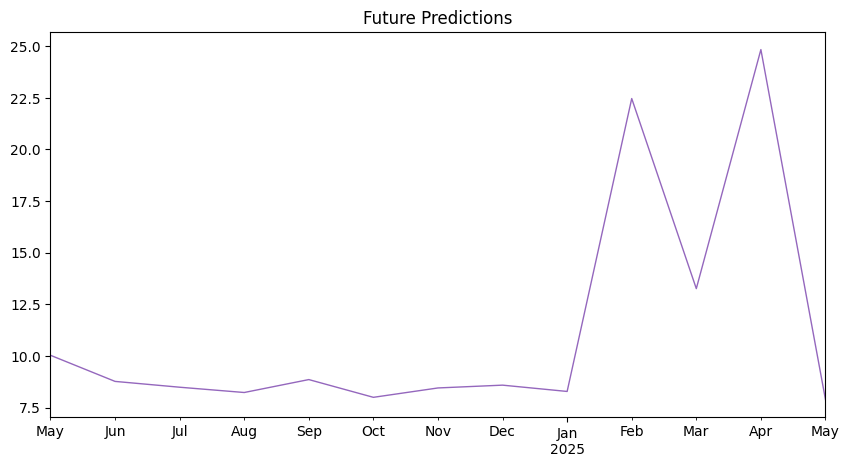

In [7]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [8]:
reg.save_model("model.json")